In [402]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler # for preprocessing the data
from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from sklearn.tree import DecisionTreeClassifier # for Decision Tree classifier
from sklearn.svm import SVC # for SVM classification
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split # to split the data
#from sklearn.cross_validation import KFold # For cross vbalidation
from sklearn.model_selection import GridSearchCV # for tunnig hyper parameter it will use all combination of given parameters
from sklearn.model_selection import RandomizedSearchCV # same for tunning hyper parameter but will use random combinations of parameters
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [403]:
data = pd.read_excel('round2.xlsx')

In [409]:
data.columns

Index(['Financial_Year ', 'Branch_Code ', 'Donation_type ', 'Donor_Age ',
       'Donation_Date ', 'Gender ', 'Blood_Group_Code', 'Donor_Weight ',
       'Donor_Temperature', 'Donor_Pulse', 'Donor_Hemoglobin',
       'Donor_Blood_Pressure', 'C1', 'C2', 'Test_3', 'Test_4', 'Year', 'Month',
       'Day'],
      dtype='object')

In [410]:
data.drop('Sequence_1', axis = 1, inplace = True)
data.drop('Sequence_2', axis = 1, inplace = True)
data.drop('Test_1', axis = 1, inplace = True)
data.drop('Test_2', axis = 1, inplace = True)

print("Dropped")

KeyError: "['Sequence_1'] not found in axis"

In [411]:
data['Donation_type '].where(data['Donation_type '].isin(['T', 'R']), data['Donation_type '].mode()[0], inplace = True)

data['Donor_Age '] = data['Donor_Age '].apply(lambda s: pd.to_numeric(s, errors = 'coerce'))
data['Donor_Age '].where((data['Donor_Age '] >= 15) & (data['Donor_Age '] <= 80), data['Donor_Age '].median(), inplace = True)

data['Donation_Date '].fillna(method = 'ffill', inplace = True)

data['Gender '].where(data['Gender '].isin(['M', 'F']), data['Gender '].mode()[0], inplace = True)

data['Blood_Group_Code'] = data['Blood_Group_Code'].apply(lambda s: pd.to_numeric(s, errors = 'coerce'))
data['Blood_Group_Code'].where((data['Blood_Group_Code'] >= 1) & (data['Blood_Group_Code'] <= 8), data['Blood_Group_Code'].mode()[0], inplace = True)

data['Donor_Weight '] = data['Donor_Weight '].apply(lambda s: pd.to_numeric(s, errors = 'coerce'))
data['Donor_Weight '].where((data['Donor_Weight '] >= 45) & (data['Donor_Weight '] <= 160), data['Donor_Weight '].median(), inplace = True)

data['Donor_Pulse'] = data['Donor_Pulse'].apply(lambda s: pd.to_numeric(s, errors = 'coerce'))
data['Donor_Pulse'].where((data['Donor_Pulse'] >= 55) & (data['Donor_Pulse'] <= 105), data['Donor_Pulse'].median(), inplace = True)

data['Donor_Hemoglobin'] = data['Donor_Hemoglobin'].apply(lambda s: pd.to_numeric(s, errors = 'coerce'))
data['Donor_Hemoglobin'].where((data['Donor_Hemoglobin'] >= 8) & (data['Donor_Hemoglobin'] <= 22), data['Donor_Hemoglobin'].median(), inplace = True)

data['Donor_Blood_Pressure'].where(data['Donor_Blood_Pressure'].isin(['120/80', '120/70', '120/90', '110/80',
                                                                      '130/80', '130/90', '120/82', '110/90',
                                                                      '140/90', '110/70', '140/80', '210/80',
                                                                      '120/85', '120-60', '120/81', '120/50',
                                                                      '121/80', '130/70', '120/83', '130/85',
                                                                      '120/78', '125/80', '120/78', '123/80']), '120/80', inplace = True)

data['Donor_Blood_Pressure'].where(data['Donor_Blood_Pressure'] != '120-60', '120/80', inplace = True)

def clean_temperature(temperature):
    clean_temp = temperature
    
    if (temperature < 1 and temperature >= 0):
        clean_temp *= 100.0
        clean_temp = clean_temperature(clean_temp)
    
    elif (temperature < 10 and temperature >= 1):
        clean_temp *= 10.0
        clean_temp = clean_temperature(clean_temp)
    
    elif (temperature < 35 and temperature >= 10):
        clean_temp = 37
    
    elif (temperature < 95 and temperature > 38):
        clean_temp = 37
    
    elif (temperature < 101 and temperature >= 95):
        clean_temp = (temperature - 32) * (5.0 / 9.0)
    
    elif (temperature < 950 and temperature >= 101):
        clean_temp = 37
    
    elif (temperature < 1010 and temperature >= 950):
        clean_temp = ((temperature / 10) - 32) * (5.0 / 9.0)
    
    return clean_temp

data['Donor_Temperature'] = data['Donor_Temperature'].apply(lambda s: pd.to_numeric(s, errors = 'coerce'))

for i in data['Donor_Temperature'].index:
    temperature = data.at[i, 'Donor_Temperature']
    if (temperature != np.nan):
        data.at[i, 'Donor_Temperature'] = clean_temperature(temperature)

data['Donor_Temperature'].fillna(37, inplace = True)

data['C1'].where(data['C1'].isin(['N', 'P' 'I']), 'P', inplace = True)
data['C2'].where(data['C2'].isin(['N', 'P' 'I']), 'P', inplace = True)

data['Test_3'].where(data['Test_3'].isin(['N', 'P']), 'P', inplace = True)
data['Test_4'].where(data['Test_4'].isin(['N', 'P']), 'P', inplace = True)

In [412]:
data['Donation_Date '] = data['Donation_Date '].map(lambda s : time.strptime(s, '%d-%b-%y'))

TypeError: strptime() argument 0 must be str, not <class 'time.struct_time'>

In [413]:
data['Year'] = data['Financial_Year '].map(lambda x: int("20" + str(x)))
data['Month'] = data['Donation_Date '].map(lambda x: x[1])
data['Day'] = data['Donation_Date '].map(lambda x: x[2])

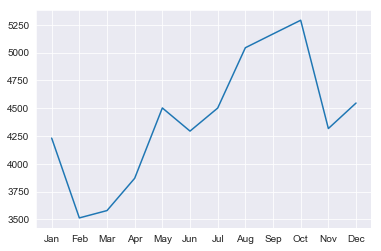

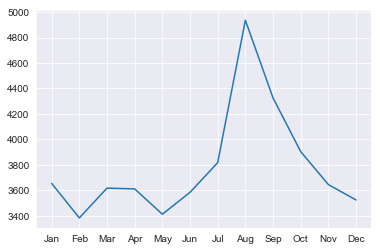

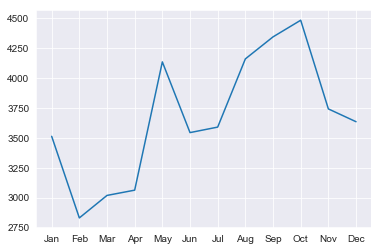

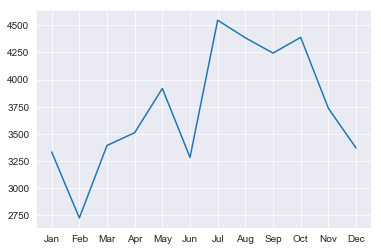

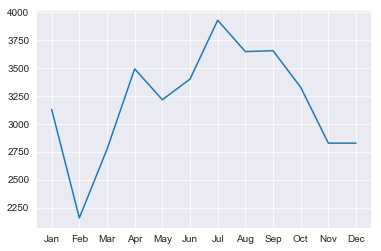

In [414]:
for i in range(2014, 2019):
    cnts = []
    
    for j in range(1, 13):
        cnts.append(data[(data['Year'] == i) & (data['Month'] == j)]['Year'].count())
    
    plt.plot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], cnts)
    plt.show()

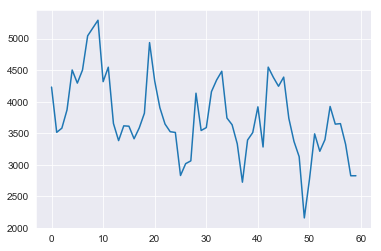

In [415]:
cnts = []

for i in range(2014, 2019):    
    for j in range(1, 13):
        cnts.append(data[(data['Year'] == i) & (data['Month'] == j)]['Year'].count())

plt.plot(cnts)
plt.show()

In [416]:
color = sns.color_palette()
sns.set_style('darkgrid')

data.head()

,Financial_Year,Branch_Code,Donation_type,Donor_Age,Donation_Date,Gender,Blood_Group_Code,Donor_Weight,Donor_Temperature,Donor_Pulse,Donor_Hemoglobin,Donor_Blood_Pressure,C1,C2,Test_3,Test_4,Year,Month,Day
0,14,BRC-01,R,24.0,"(2013, 7, 1, 0, 0, 0, 0, 182, -1)",M,5.0,56.0,37.0,72.0,13.0,120/80,N,N,P,N,2014,7,1
1,14,BRC-01,R,33.0,"(2013, 7, 1, 0, 0, 0, 0, 182, -1)",M,3.0,75.0,37.0,72.0,13.0,120/80,N,N,N,N,2014,7,1
2,14,BRC-01,R,28.0,"(2013, 7, 1, 0, 0, 0, 0, 182, -1)",M,5.0,65.0,37.0,72.0,13.0,120/80,N,N,N,N,2014,7,1
3,14,BRC-01,R,20.0,"(2013, 7, 1, 0, 0, 0, 0, 182, -1)",M,3.0,65.0,37.0,72.0,13.0,120/80,N,N,N,N,2014,7,1
4,14,BRC-01,T,22.0,"(2013, 7, 1, 0, 0, 0, 0, 182, -1)",M,7.0,75.0,37.0,72.0,13.0,120/80,N,N,N,N,2014,7,1


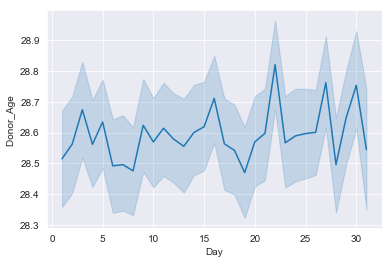

In [417]:
sns.lineplot(x="Day", y="Donor_Age ",legend = 'full' , data=data)


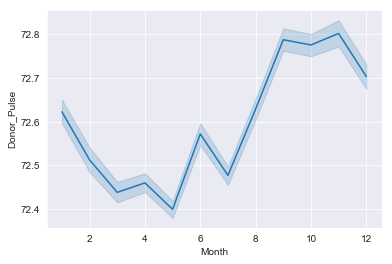

In [418]:
sns.lineplot(x="Month", y="Donor_Pulse",legend = 'full' , data=data)


0     True
1    False
2    False
3    False
4    False
Name: Y, dtype: bool

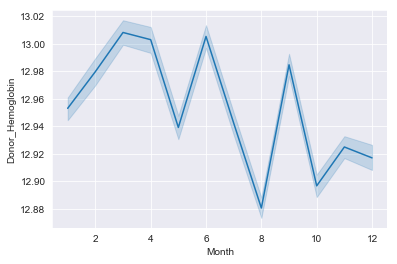

In [459]:
sns.lineplot(x="Month", y="Donor_Hemoglobin",legend = 'full' , data=data)
data['Y'].head()

# cnts = []

# for i in range(2014, 2019):    
#     for j in range(1, 13):
#         cnts.append(data[(data['Year'] == i) & (data['Month'] == j) & (data['Y'] == 1)])

# plt.plot(cnts)
# plt.show()


In [457]:
sns.lineplot(x=("Month", "Year"), y="Y",legend = 'full' , data=data)


ValueError: array length 2 does not match index length 225498

In [420]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
     #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

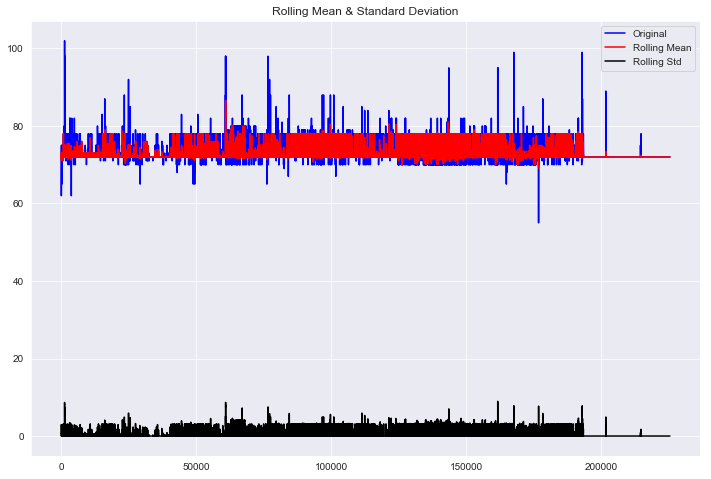

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                    -62.052666
p-value                             0.000000
#Lags Used                         20.000000
Number of Observations Used    225477.000000
Critical Value (1%)                -3.430379
Critical Value (5%)                -2.861553
Critical Value (10%)               -2.566777
dtype: float64


In [421]:
test_stationarity(data['Donor_Pulse'])


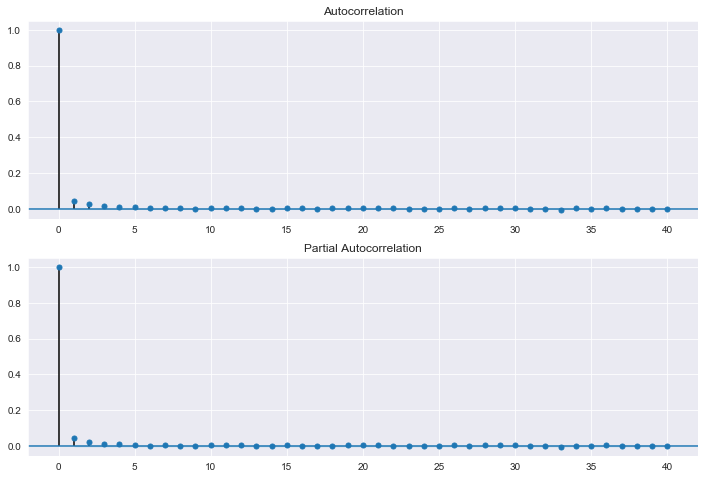

In [422]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Blood_Group_Code'], lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Blood_Group_Code'], lags=40, ax=ax2)#

In [423]:
# sepereating 'object' columns with float/int and putting them together 
# exluding objects that have > 10 unique data types
low_cardinality_cols = [cname for cname in data.columns if data[cname].nunique() < 10 and data[cname].dtype == 'object']
numeric_cols = [cname for cname in data.columns if data[cname].dtype in ['int64', 'float64']]
my_cols = low_cardinality_cols + numeric_cols
train_predictors = data[my_cols]
test_predictors = data[my_cols]

In [443]:
data['Y'] = ((data.C1=='P') | (data.C2 =='P') | (data.Test_3=='P') | (data.Test_4=='P'))

data['Y'].value_counts()

target = data['Y']

In [444]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data[['Financial_Year ', 'Branch_Code ', 'Donation_type ', 'Donor_Age ',
       'Donation_Date ', 'Gender ', 'Blood_Group_Code', 'Donor_Weight ',
       'Donor_Temperature', 'Donor_Pulse', 'Donor_Hemoglobin',
       'Donor_Blood_Pressure', 'C1', 'C2', 'Test_3', 'Test_4', 'Year', 'Month',
       'Day']],target,random_state=42)

In [445]:
# Get Dummies 
one_hot_encoded_training_predictors = pd.get_dummies(X_train_2)
one_hot_encoded_test_predictors = pd.get_dummies(X_test_2)

In [446]:
one_hot_encoded_training_predictors.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 169123 entries, 45958 to 121958
Columns: 1908 entries, Financial_Year  to Test_4_P
dtypes: float64(6), int64(4), uint8(1898)
memory usage: 320.3 MB


In [447]:
data.columns

Index(['Financial_Year ', 'Branch_Code ', 'Donation_type ', 'Donor_Age ',
       'Donation_Date ', 'Gender ', 'Blood_Group_Code', 'Donor_Weight ',
       'Donor_Temperature', 'Donor_Pulse', 'Donor_Hemoglobin',
       'Donor_Blood_Pressure', 'C1', 'C2', 'Test_3', 'Test_4', 'Year', 'Month',
       'Day', 'Y'],
      dtype='object')

In [453]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

def get_MeanAbsoluteError(X, y):
    return -1 * cross_val_score(RandomForestRegressor(20), X, y, scoring = 'neg_mean_absolute_error').mean()


predictors_without_categoricals = X_train_2.select_dtypes(exclude=['object'])
#predictors_without_categoricals = predictors_without_categoricals.drop('Y',axis=1)

print(predictors_without_categoricals.head())
print(one_hot_encoded_training_predictors.info())
mae_without_categoricals = get_MeanAbsoluteError(predictors_without_categoricals, X_train_2)

mae_one_hot_encoded = get_MeanAbsoluteError(one_hot_encoded_training_predictors, X_test_2)

#print("Mean absolute error when dropping categoricals: " + str(int(mae_without_categoricals)))
#print("Mean absolute error with one-hot encoding: " + str(int(mae_one_hot_encoded)))



        Financial_Year   Donor_Age   Blood_Group_Code  Donor_Weight   \
45958                15        25.0               5.0           80.0   
173611               18        19.0               1.0           75.0   
86159                16        35.0               5.0           71.0   
57181                15        29.0               5.0           65.0   
88210                16        41.0               5.0           78.0   

        Donor_Temperature  Donor_Pulse  Donor_Hemoglobin  Year  Month  Day  
45958                37.0         78.0              12.0  2015      7   16  
173611               37.0         72.0              14.0  2018     11   15  
86159                37.0         72.0              13.0  2016      8   25  
57181                37.0         72.0              13.0  2015     10   22  
88210                37.0         72.0              13.0  2016      9   12  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 169123 entries, 45958 to 121958
Columns: 1908 entries, 

ValueError: could not convert string to float: 'N'